In [3]:
import torch
from torch import nn
from torchvision import datasets, transforms
from pathlib import Path

In [4]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [5]:
trivial_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.TrivialAugmentWide(6),
    transforms.ToTensor()
])

In [6]:
from torchvision.transforms import ToTensor

root_data = Path("data/")

train_data = datasets.MNIST(root=root_data,
                            train=True,
                            transform=trivial_transform,
                            download=True)

test_data = datasets.MNIST(root=root_data,
                           train=False,
                           transform=ToTensor(),
                           download=True)

In [7]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Text(0.5, 1.0, '5 - five')

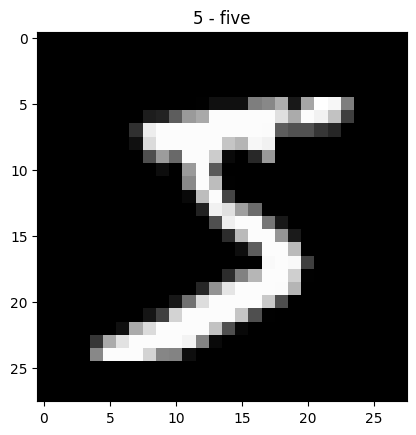

In [17]:
import matplotlib.pyplot as plt
image = train_data[0][0]
plt.imshow(image.permute(1, 2, 0), cmap="gray")
plt.title(class_names[train_data[0][1]])

In [18]:
from torch.utils.data import DataLoader 

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=1)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=1)

In [19]:
def acc_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [20]:
class MNIST_CNN(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [23]:
def train_step(model,
               train_dataloader,
               loss_fn,
               optimizer,
               acc_fn):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to('mps'), y.to('mps')
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += acc_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    return train_loss, train_acc


In [24]:
def test_step(model,
              test_dataloader,
              loss_fn,
              acc_fn):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader):
            X, y = X.to('mps'), y.to('mps')
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss
            acc = acc_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            test_acc += acc
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    return test_loss, test_acc

In [25]:
model = MNIST_CNN(input_shape=1,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

In [26]:
from tqdm.auto import tqdm

EPOCHS = 20

for epoch in tqdm(range(EPOCHS)):
    print(f"EPOCH: {epoch + 1}")
    train_loss, train_acc = train_step(model=model,
                                       train_dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       acc_fn=acc_fn)
    print(f"Train loss: {train_loss:.2f} | Train acc: {train_acc:.2f}")
    test_loss, test_acc = test_step(model=model,
                                    test_dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    acc_fn=acc_fn)
    print(f"Test loss: {test_loss:.2f} | Test acc: {test_acc:.2f}")
    

/Users/kazikgarstecki/Desktop/workspace/github.com/kazgar/cnn_mnist/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH: 1
Train loss: 0.89 | Train acc: 71.27


  5%|▌         | 1/20 [00:21<06:43, 21.25s/it]

Test loss: 0.09 | Test acc: 97.17
EPOCH: 2
Train loss: 0.55 | Train acc: 82.13


 10%|█         | 2/20 [00:40<06:01, 20.10s/it]

Test loss: 0.14 | Test acc: 95.42
EPOCH: 3
Train loss: 0.47 | Train acc: 84.43


 15%|█▌        | 3/20 [00:59<05:31, 19.52s/it]

Test loss: 0.06 | Test acc: 97.97
EPOCH: 4
Train loss: 0.42 | Train acc: 85.90


 20%|██        | 4/20 [01:18<05:06, 19.18s/it]

Test loss: 0.06 | Test acc: 97.94
EPOCH: 5
Train loss: 0.41 | Train acc: 86.33


 25%|██▌       | 5/20 [01:35<04:39, 18.66s/it]

Test loss: 0.05 | Test acc: 98.32
EPOCH: 6
Train loss: 0.38 | Train acc: 87.01


 30%|███       | 6/20 [01:53<04:16, 18.35s/it]

Test loss: 0.05 | Test acc: 98.38
EPOCH: 7
Train loss: 0.37 | Train acc: 87.47


 35%|███▌      | 7/20 [02:13<04:05, 18.87s/it]

Test loss: 0.06 | Test acc: 98.17
EPOCH: 8
Train loss: 0.36 | Train acc: 87.89


 40%|████      | 8/20 [02:33<03:49, 19.16s/it]

Test loss: 0.04 | Test acc: 98.70
EPOCH: 9
Train loss: 0.35 | Train acc: 88.21


 45%|████▌     | 9/20 [02:52<03:30, 19.17s/it]

Test loss: 0.05 | Test acc: 98.43
EPOCH: 10
Train loss: 0.34 | Train acc: 88.44


 50%|█████     | 10/20 [03:11<03:12, 19.29s/it]

Test loss: 0.05 | Test acc: 98.36
EPOCH: 11
Train loss: 0.33 | Train acc: 88.61


 55%|█████▌    | 11/20 [03:30<02:52, 19.18s/it]

Test loss: 0.04 | Test acc: 98.60
EPOCH: 12
Train loss: 0.33 | Train acc: 88.84


 60%|██████    | 12/20 [03:49<02:31, 18.97s/it]

Test loss: 0.04 | Test acc: 98.59
EPOCH: 13
Train loss: 0.33 | Train acc: 88.86


 65%|██████▌   | 13/20 [04:09<02:14, 19.22s/it]

Test loss: 0.04 | Test acc: 98.78
EPOCH: 14
Train loss: 0.32 | Train acc: 89.08


 70%|███████   | 14/20 [04:27<01:53, 18.99s/it]

Test loss: 0.04 | Test acc: 98.66
EPOCH: 15
Train loss: 0.32 | Train acc: 89.05


 75%|███████▌  | 15/20 [04:46<01:34, 18.89s/it]

Test loss: 0.03 | Test acc: 98.96
EPOCH: 16
Train loss: 0.31 | Train acc: 89.23


 80%|████████  | 16/20 [05:05<01:16, 19.11s/it]

Test loss: 0.03 | Test acc: 98.83
EPOCH: 17
Train loss: 0.30 | Train acc: 89.72


 85%|████████▌ | 17/20 [05:24<00:56, 18.95s/it]

Test loss: 0.04 | Test acc: 98.67
EPOCH: 18
Train loss: 0.31 | Train acc: 89.49


 90%|█████████ | 18/20 [05:44<00:38, 19.22s/it]

Test loss: 0.04 | Test acc: 98.84
EPOCH: 19
Train loss: 0.30 | Train acc: 89.56


 95%|█████████▌| 19/20 [06:04<00:19, 19.36s/it]

Test loss: 0.04 | Test acc: 98.80
EPOCH: 20
Train loss: 0.30 | Train acc: 89.55


100%|██████████| 20/20 [06:23<00:00, 19.20s/it]

Test loss: 0.04 | Test acc: 98.94


In [27]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "MNIST_CNN2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH) 
